# **Imports & Settings**

In [1]:
from utils_data_prep import *

import os
import glob
import json

import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# set dataframe display options to show decimal format (not scientific notation)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
#######################
# Initial Folder Setup
#######################

# path to data directory
data_dir = r'../data'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
else:
    print(f"Directory - {data_dir} - already exists...")


# path to warren county data directory
warren_dir = r'../data/warren'
if not os.path.isdir(warren_dir):
    os.makedirs(warren_dir)
else:
    print(f"Directory - {warren_dir} - already exists...")

Directory - ../data - already exists...
Directory - ../data/warren - already exists...


# **Labeled Target Dataset**

***OVERVIEW***
* Since 2004, the Kentucky Geological Survey has focused on detailed surficial geologic mapping across the state, with recent efforts concentrated on Hardin and Warren Counties. These areas offer the most accurate and available geologic GIS datasets in Kentucky.

* Warren County's surficial geology is shaped by three primary geological processes: in-situ weathering of bedrock, gravity-driven sediment deposition, and fluvial sediment transportation and deposition. These processes result in seven distinct geologic map units, each defined by unique textural, compositional, and topographic characteristics.


    1. **Artificial fill (af1).** Man-made deposits of soil, sand, gravel, concrete, asphalt, or other materials used to alter the landscape, typically associated with construction activities such as road building, land leveling, or embankment creation.

    2. **Alluvium (Qal).** Unconsolidated clastic sediments, including clay, silt, sand, and gravel, deposited by fluvial processes in riverbeds, floodplains, or deltas, often characterized by stratification and sorting.
    
    3. **Alluvial fans (Qaf).** Cone-shaped deposits of sediment that form where high-gradient streams experience a sudden decrease in flow velocity, causing a rapid deposition of material ranging from fine silt to coarse gravel. Considered a sub-unit of alluvium.

    4. **Alluvial terraces (Qat).** Fluvial sediments left behind on former floodplain levels as a river downcuts into its valley, forming step-like terraces that represent previous stages of river activity. Considered a sub-unit of alluvium.

    5. **Colluvium (Qc).** Unsorted and unconsolidated material, primarily consisting of soil and rock fragments, that has accumulated along the sides of steep slopes due to gravitational forces, often mixed with organic material and poorly stratified.

    6. **Colluvial accumulation zones (Qca).** Wedge-shaped deposits of colluvium at the bases of slopes where colluvium has accumulated due to the lack of gravitational force necessary for further sediment transportation. Considered a sub-unit of colluvium.
    
    7. **Residuum (Qr).** Weathered rock material that remains in situ above its parent bedrock, resulting from prolonged chemical and physical weathering processes, and often forming the basis for soil development directly over the source rock.

***PURPOSE***
* The MapUnitsPolys feature class consists of polygons representing the aerial extent of these surficial geologic map units. These polygons serve as the labeled target dataset for training, validation, and testing in this deep learning segmentation project.

## *Surficial Geologic Map Polygons*

In [ ]:
###########################
# Download Map Geodatabase
###########################

# url to download zipped geodatabase
url = r''

# output path to save geodatabase
gdb_dir = r'../data/warren/geology'
if not os.path.isdir(gdb_dir):
    os.makedirs(gdb_dir)


##### custom function to download geodatabase
download_zip(url, gdb_dir)

In [3]:
############################
# Save Map Layer as GeoJSON
############################

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# name of geodatabase layer containing polygons
map_layer = 'warren_geo'

# path for output GeoJSON
output_path = r'../data/warren/geology.geojson'


##### verify polygons & save as GeoJSON
if not os.path.isfile(output_path):
    
    gdf = gpd.read_file(gdb_path, layer=map_layer)
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    if gdf.is_valid.all():
        gdf.to_file(output_path, driver='GeoJSON')
    
    else:
        print('Something is wrong with polygons...')

else:
    print('Output file already exists...')

In [4]:
################################################
# Convert GeoJSON to GeoTIFF with Metadata JSON
################################################

# path to GeoJSON to convert to image
input_path = r'../data/warren/geology.geojson'

# resolution of output image (in pixels)
output_resolution = 5

# attribute to use as category in raster (if none, then output image is binary)
attribute = 'Symbol'

# path to output image (and JSON metadata)
output_path = r'../data/warren/geology.tif'


##### custom function to convert GeoJSON to GeoTIFF with JSON metadata
gis_to_image(input_path, output_path, output_resolution, attribute)

## *Dataset Boundaries*

In [6]:
###########################
# Save Boundary as GeoJSON
###########################

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# name of geodatabase layer containing boundary polygon
boundary_layer = 'warren_geo_boundary'

# path for output GeoJSON
output_path = r'../data/warren/boundary.geojson'


##### verify polygon & save as GeoJSON
if not os.path.isfile(output_path):
    gdf = gpd.read_file(gdb_path, layer=boundary_layer)
    if gdf.is_valid.all():
        gdf.to_file(output_path, driver='GeoJSON')
    else:
        print('Something is wrong with polygon...')
else:
    print(f"File - {output_path} - already exists...")

File - ../data/warren/boundary.geojson - already exists...


In [7]:
#############################################
# Create Buffered Boundary & Save as GeoJSON
#############################################

# path to boundary GeoJSON
input_path = r'../data/warren/boundary.geojson'

# buffer distance in native CRS spatial units (feet for this project)
# NOTE: buffer distance should be enough to mitigate edge effects for terrain feature calculations (i.e., calculations using window/neighborhood)
buffer_distance = 1000

# path for output GeoJSON
output_path = f"../data/warren/boundary_buffer{buffer_distance}.geojson"


##### create buffered boundary & save 
if not os.path.isfile(output_path):
    gdf = gpd.read_file(input_path)
    gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    gdf.to_file(output_path, driver='GeoJSON')

else:
    print(f"File - {output_path} - already exists...")

File - ../data/warren/boundary_buffer1000.geojson - already exists...


## *Visualize Target & Boundaries*

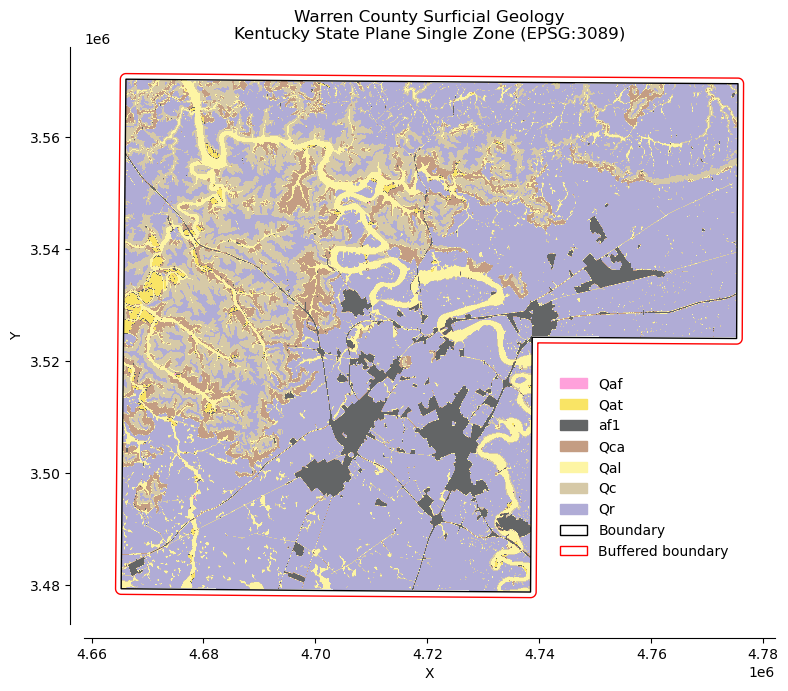

In [9]:
###############################################
# Visualize Target GeoTIFF & Boundary GeoJSONs
###############################################

# path to GeoTIFF
geo_path = r'../data/warren/geology.tif'

# path to JSON metadata
geo_meta_path = r'../data/warren/geology.json'

# path to dataset boundary
boundary_path = r'../data/warren/boundary.geojson'

# path to buffered dataset boundary
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]


##### create custom color map from GeoTIFF metadata JSON
with open(geo_meta_path, 'r') as meta:
    geo_meta = json.load(meta)

colors = {'af1': '#636566', 
          'Qal': '#fdf5a4', 
          'Qaf': '#ffa1db', 
          'Qat': '#f9e465', 
          'Qc': '#d6c9a7', 
          'Qca': '#c49d83', 
          'Qr': '#b0acd6'}

cmap = ListedColormap([colors[symbol] for symbol in geo_meta.keys()])


##### visualize GeoTIFF with custom colormap & boundaries
fig, ax = plt.subplots(figsize=(8,8))

# plot GeoTIFF with custom color map
with rasterio.open(geo_path) as src:
    show(src, ax=ax, cmap=cmap)

# plot custom legend
handles = [Patch(color=colors[symbol], label=symbol) for symbol in geo_meta.keys()]

# plot dataset boundaries
boundary = gpd.read_file(boundary_path)
boundary.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1)
boundary_patch = Patch(facecolor='none', edgecolor='k', linewidth=1, label='Boundary')
handles.append(boundary_patch)

buffered = gpd.read_file(buffered_path)
buffered.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
buffered_patch = Patch(facecolor='none', edgecolor='red', linewidth=1, label='Buffered boundary')
handles.append(buffered_patch)

# adjust figure styling
ax.legend(handles=handles, bbox_to_anchor=(0.67, 0.45), loc='upper left', frameon=False)
ax.set_title('Warren County Surficial Geology\nKentucky State Plane Single Zone (EPSG:3089)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 10))  # offset bottom axis
ax.spines['left'].set_position(('outward', 10))    # offset left axis

plt.tight_layout()
plt.show()

# **KyFromAbove Tile Index**

***OVERVIEW***
* The KyFromAbove 5K tile index is available as a geodatabase containing three polygon feature classes for accessing digital elevation models (DEMs), aerial imagery, and LiDAR point cloud datasets. These feature classes represent grids of individual tiles, each corresponding to a specific area. The tiles can be downloaded as GeoTIFF images, with each tile featuring various attributes, including download URLs. More information can be found at the KyFromAbove website - https://kyfromabove.ky.gov/

***PURPOSE***
* The tile index is essential for identifying and accessing the specific DEM and aerial imagery GeoTIFF images that correspond to the area of interest covered by the target map datasets. Although the tile index itself is not directly used as a feature, it facilitates the retrieval of the necessary data for further analysis.

In [8]:
################################################
# Download & Save Index Tile Layers as GeoJSONs
################################################

# directory path to save files
output_dir = r'../data/index_tiles'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)


##### download index tile geodatabase & save layers as GeoJSONs
if len(glob.glob(f"{output_dir}/*.geojson")) > 0:
    for file in glob.glob(f"{output_dir}/*.geojson"):
        print(f"Output file - {file} - already exists...")
else:
    get_tile_index(output_dir)


##### delete point cloud index file
for file in glob.glob(f"{output_dir}/*.geojson"):
    if 'pointcloud' in file.lower():
        os.remove(file)

Output file - ../data/index_tiles/KYAPED_Aerial_Tile_Index.geojson - already exists...
Output file - ../data/index_tiles/KYAPED_5FT_DEM_Tile_Index.geojson - already exists...


In [9]:
#############################################
# Extract Tiles that Intersect Warren County
#############################################

# list of paths to statewide tile index GeoJSONs (for DEM & Aerial Imagery)
index_paths = glob.glob(r'../data/index_tiles/*.geojson')

# path to buffered dataset boundary GeoJSON
# NOTE: buffered boundary is used to ensure all tiles are necessary tiles are retrieved
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]


###### save Warren County tile index polygons as GeoJSONs
for path in index_paths:

    filename = os.path.basename(path) 
    output_path = f"../data/warren/warren_{filename}"

    if not os.path.isfile(output_path):
        get_intersecting_index_tiles(path, boundary_path, output_path)
        
    else:
        print(f"Output file - {output_path} - already exists...")

Output file - ../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson - already exists...
Output file - ../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson - already exists...


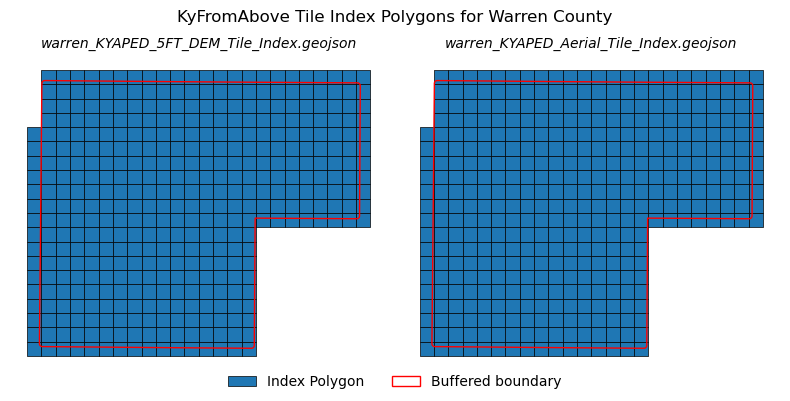

In [5]:
####################################################
# Visualize Index Tiles & Buffered Dataset Boundary
####################################################

# list of paths to index tiles
index_paths = glob.glob(r'../data/warren/*Index*.geojson')

# path to buffered dataset boundary
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]


##### read GeoJSONs as geodataframes & visualize coverage
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

buffered = gpd.read_file(buffered_path)

for idx, path in enumerate(index_paths):
    name = os.path.basename(path)
    index = gpd.read_file(path)
    index.plot(ax=ax[idx], edgecolor='k', linewidth=0.5)
    buffered.plot(ax=ax[idx], facecolor='none', edgecolor='red', linewidth=1)
    ax[idx].set_title(name, style='italic', fontsize=10)
    ax[idx].set_axis_off()

buffered_patch = Patch(facecolor='none', edgecolor='red', linewidth=1, label='Buffered boundary')
index_patch = Patch(edgecolor='k', linewidth=0.5, label='Index Polygon')
handles = [index_patch, buffered_patch]
plt.figlegend(handles=handles, loc='lower center', frameon=False, ncols=2)

plt.suptitle('KyFromAbove Tile Index Polygons for Warren County', y=0.97)
plt.tight_layout()
plt.show()

# **Digital Elevation Model (DEM)**

***OVERVIEW***
* The Kentucky statewide digital elevation model (DEM) is generated from airborne LiDAR data collected since 2010. The data collection was divided into phases: Phase 1 produced a DEM with a 5-foot resolution, while Phase 2 resulted in a more detailed 2-foot resolution DEM. These datasets are publicly accessible in small tiles available for download in either .img (with associated metadata files) or .tif (GeoTIFF) formats. This project will utilize the Phase 1 5 foot DEM.

***PURPOSE***
* The DEM serves as a fundamental base layer for interpreting and delineating surficial geologic map units in this project. The DEM also enables the derivation of multiple terrain features and indices, which provide additional insights and are calculated in a subsequent section.

In [6]:
###############################################
# Download DEM GeoTIFF tiles for Warren County
###############################################

# path to DEM tile index GeoJSON for Warren County
index_path = glob.glob(r'../data/warren/*DEM_Tile_Index.geojson')[0]

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing GeoTIFF download url
url_field = 'Phase1_AWS_url'

# output directory to save downloaded tiles
output_dir = r'../data/warren/dem_tiles'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)


###### call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [3]:
###########################################
# Mosaic DEM Tiles into Single DEM GeoTIFF
###########################################

# path to buffered boundary geojson file
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]

# path to geojson containing tile polygons
index_path = glob.glob(r'../data/warren/*DEM*.geojson')[0]

# directory containing dem tiles
dem_dir = r'../data/warren/dem_tiles'
if not os.path.isdir(dem_dir):
    os.makedirs(dem_dir)

# path for output dem
output_path = r'../data/warren/dem.tif'


##### get lists of paths for tiles along boundary edges & tiles completely within boundary
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(index_path, buffered_path, dem_dir)


##### iterate through edge tiles and clip these tiles to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, buffered_path)


##### get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{dem_dir}/*clip.tif")
tile_paths = within_tile_paths + clipped_edge_tile_paths


##### mosaic clipped edge and contained tiles into single dem and save
mosaic_image_tiles(tile_paths, output_path)

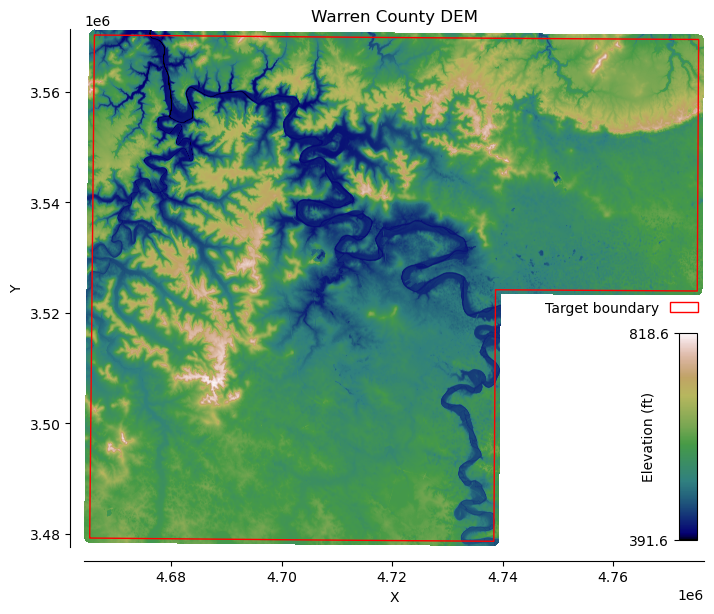

In [15]:
########################
# Visualize Clipped DEM
########################

# path to dem mosaic
dem_path = r'../data/warren/dem.tif'

# path to target boundary (not buffered)
boundary_path = r'../data/warren/boundary.geojson'


##### plot dem
fig, ax = plt.subplots(figsize=(8,8))

with rasterio.open(dem_path) as dem:
    data = dem.read(1, masked=True)
    min_val = np.min(data)
    max_val = np.max(data)
    bounds = dem.bounds
    dem_hidden = ax.imshow(data, cmap='gist_earth', interpolation='bicubic')
    show(dem, ax=ax, cmap='gist_earth')
    
cax = inset_axes(ax, width='3%', height='40%', loc='lower right')
cbar = fig.colorbar(dem_hidden, cax=cax, ticks=[min_val, max_val])
cax.yaxis.set_ticks_position('left')
cbar.set_label('Elevation (ft)', labelpad=-40)

boundary = gpd.read_file(boundary_path)
boundary.plot(ax=ax, facecolor='none', edgecolor='red')
boundary_patch = Patch(facecolor='none', edgecolor='red', label='Target boundary')
ax.legend(handles=[boundary_patch], loc='upper left', bbox_to_anchor=(0.925, 0.5), frameon=False, handletextpad=-11)

ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)
ax.set_title('Warren County DEM')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_position(('outward', 10))
    
plt.show()

In [38]:
####################################
# Delete Tiles for Space (optional)
####################################

# directory path to dem tiles
dem_dir = r'../data/warren/dem_tiles'


##### delete dem_tiles folder and all contents
if os.path.isdir(dem_dir):
    shutil.rmtree(dem_dir)

# **Terrain Features**

***OVERVIEW***
* Terrain features are derived from the DEM to characterize the topography and capture features that are critical for identifying and delineating surficial geologic map units. These features provide supplementary data about topography, weathering processes, water drainage patterns, and vegetation that enhance the interpretation of geologic processes and landforms, contributing to more accurate predictions.

***PURPOSE***
* Eight terrain features are calculated from the DEM, each providing unique insights into the landscape's characteristics:

    1. **Slope.** Measures the steepness or incline of the terrain. It is critical for identifying areas prone to erosion, landslides, or specific deposition patterns associated with certain geologic map units.

    2. **Aspect.** The compass direction that a slope faces. Aspect influences microclimates, vegetation types, and weathering processes, all of which are important in understanding surficial geology.

    3. **Profile Curvature.** Indicates the curvature of the terrain in the direction of the slope. It affects the acceleration or deceleration of water flow, which can influence erosion and sediment deposition patterns.

    4. **Plan Curvature.** Measures the curvature perpendicular to the slope direction. It helps in identifying convergent and divergent flow patterns, which are important for understanding water drainage and sediment deposition.

    5. **Standard Deviation of Slope.** Provides a measure of the variability in slope within a given area. It is useful for identifying areas with complex topography, which may correlate with different geologic processes or materials.

    6. **Topographic Position Index (TPI).** Compares the elevation of each point to the mean elevation of surrounding points. TPI is useful for identifying ridges, valleys, and flat areas, each of which may correspond to different geologic map units.

    7. **Height Above Nearest Drainage (HAND).** Calculates the relative height of each point above the nearest drainage channel. HAND is important for understanding flood potential, sediment transport, and the relationship between elevation and water flow.

    8. **Elevation Contour Lines.** These lines represent constant elevation and help visualize the topography in a more intuitive way. Contour lines are essential for understanding the shape of the land surface and for manual interpretation of terrain features.

## *Slope*

# **Aerial Imagery**

***OVERVIEW***
* Aerial imagery has been collected alongside LiDAR data as part of the KyFromAbove program, providing high-resolution coverage across Kentucky. The imagery is available with resolutions ranging from 1 foot to 3 inches, with a standard statewide resolution of 6 inches. Although the program captures true color imagery (RGB) across the state, some areas also include near-infrared (NIR) as a fourth band. These four-band images are accessible for download, offering detailed visual information about the landscape.

***PURPOSE***
* The four-band aerial imagery (RGB + NIR) plays a specific role in predicting certain surficial geologic map units. This imagery is particularly useful for identifying artificial fill, as man-made structures and disturbed land are easily distinguishable from natural landscapes. Additionally, the imagery may help in recognizing areas of alluvium or stream channels, especially where vegetation patterns (visible through the NIR band) can indicate the presence of water or recent sediment deposition. While the imagery may not be as effective for delineating all surficial map units, its value lies in enhancing the identification of human-altered landscapes and specific hydrological features.

* There may be a temporal discrepancy between the DEM and aerial imagery datasets, as they could have been captured at different times. This discrepancy can introduce challenges in analysis, particularly in areas where topographic changes have occurred between the collection dates, potentially affecting the consistency and accuracy of the derived features.

In [2]:
##################################################
# Download Aerial Imagery Tiles for Warren County
##################################################

# path to aerial imagery tile index GeoJSON
index_path = glob.glob(r'../data/warren/*Aerial_Tile_Index.geojson')[0]

# field containing unique tile id
id_field = 'TileName'

# field containing TIFF download url
url_field = 'Boxzip2021'

# output directory to save downloaded tiles
output_dir = r'../data/warren/aerial_tiles'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)


##### call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [3]:
#########################
# Convert RGB+NIR dtypes
#########################

# paths to aerial imagery files
aerial_tile_paths = glob.glob(r'../data/warren/aerial_tiles/*.*')


##### custom function for converting aerial image tiles to float32 with nan for nodata
for path in aerial_tile_paths:
    if '.tif' in path:
        convert_image_dtype(path)


##### delete original uint8 files & keep float32 files (to free disk space); optional
for path in aerial_tile_paths:
    if '_f32' in path:
        continue
    else:
        os.remove(path)

In [4]:
############################################################
# Mosaic aerial imagery tiles into single channel GeoTIFFs
############################################################

# path to geojson containing tile polygons
index_path = glob.glob(r'../data/warren/*Aerial_Tile_Index.geojson')[0]

# path to buffered boundary geojson file
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]

# path to directory containing aerial tiles
aerial_tile_dir = r'../data/warren/aerial_tiles'

# path to reference image for alignment (match to DEM)
# reference_path = r'../data/warren/dem.tif'


##### get lists of paths of edge tiles & contained tiles
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(index_path, buffered_path, aerial_tile_dir)


##### iterate through edge tiles and clip to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, buffered_path)


##### get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
tile_paths_list = within_tile_paths + clipped_edge_tile_paths


##### iterate through bands and mosaic clipped edge and contained tiles into single image and save...
band_names = ['r', 'g', 'b', 'nir']
for i, band in enumerate(band_names, start=1):
    aerial_path = f"../data/warren/aerial_{band}_5ft.tif"
    mosaic_image_tiles(tile_paths_list, aerial_path, band_number=i, resample=(5,5))
    # reproject_image_to_reference(aerial_path, reference_path)

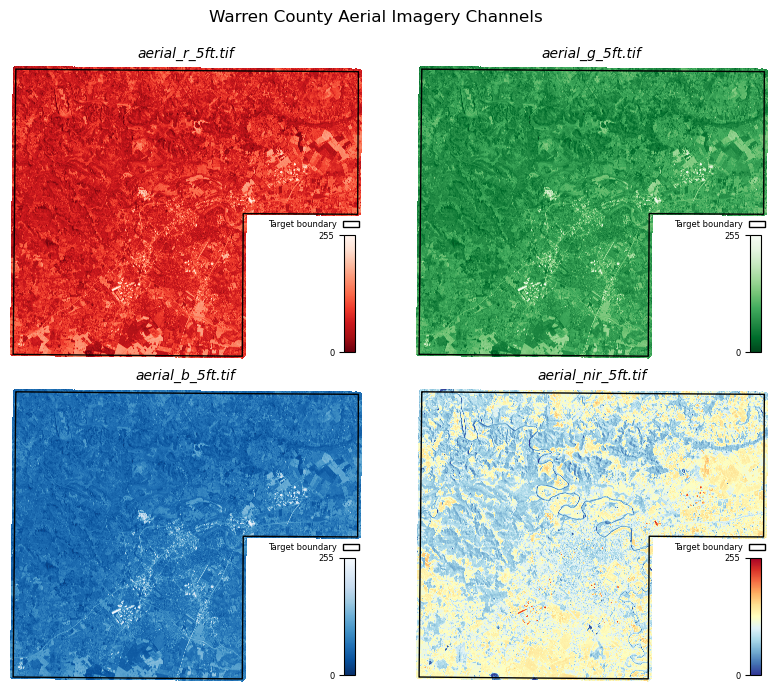

In [13]:
##################################
# Visualize Clipped Aerial Mosaic
##################################

# paths to aerial image mosaics
aerial_paths = [r'../data/warren/aerial_r_5ft.tif', 
                r'../data/warren/aerial_g_5ft.tif', 
                r'../data/warren/aerial_b_5ft.tif', 
                r'../data/warren/aerial_nir_5ft.tif',]

# list of color maps for images
cmaps = ['Reds_r', 'Greens_r', 'Blues_r', 'RdYlBu_r']

# path to target dataset boundary
boundary_path = r'../data/warren/boundary.geojson'


##### plot images & boundary
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

for idx, (path, cmap) in enumerate(zip(aerial_paths, cmaps)):
    with rasterio.open(path) as image:
        data = image.read(1, masked=True)
        bounds = image.bounds
        hidden = ax[idx].imshow(data, cmap=cmap, vmin=0, vmax=255)
        show(image, ax=ax[idx], cmap=cmap)
    cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
    cbar = fig.colorbar(hidden, cax=cax, ticks=[0, 255])
    cax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=6)

    boundary = gpd.read_file(boundary_path)
    boundary.plot(ax=ax[idx], facecolor='none', edgecolor='k')
    boundary_patch = Patch(facecolor='none', edgecolor='k', label='Target boundary')
    ax[idx].legend(handles=[boundary_patch], loc='upper left', bbox_to_anchor=(0.925, 0.5), frameon=False, handletextpad=-11, fontsize=6)

    ax[idx].set_xlim(bounds.left, bounds.right)
    ax[idx].set_ylim(bounds.bottom, bounds.top)
    ax[idx].set_title(os.path.basename(path), style='italic', fontsize=10)
    ax[idx].set_axis_off()

plt.suptitle('Warren County Aerial Imagery Channels', y=0.95)
plt.show()

In [28]:
####################################
# Delete Tiles for Space (optional)
####################################

# directory path to dem tiles
aerial_dir = r'../data/warren/aerial_tiles'


##### delete aerial_tiles folder and all contents
if os.path.isdir(aerial_dir):
    shutil.rmtree(aerial_dir)

# **Hydrography**

**OVERVIEW**
* The NHDPlus High Resolution (HR) dataset is a comprehensive geospatial resource that maps the flow of water across the United States, integrating stream networks, water bodies, and landscape features. Built using the National Hydrography Dataset (NHD) at a scale of 1:24,000 or finer, along with high-resolution elevation data from the 3D Elevation Program and the Watershed Boundary Dataset, NHDPlus HR provides detailed and accurate representations of hydrography. This dataset is crucial for hydrological analysis, environmental modeling, and understanding the interaction between water and the landscape. More information can be found in the USGS publication - https://pubs.usgs.gov/publication/ofr20191096.

**PURPOSE**
* The NHDPlus HR dataset includes two key features that will be integrated into this project:

    1. **NHDFlowline.** Stream centerlines represent the flow paths of rivers and streams, capturing the direction and connectivity of water flow across the landscape. These centerlines are essential for identifying and delineating areas of alluvium, as they highlight where water-driven sediment transport and deposition are most likely to occur.

    2. **NHDWaterbody.** The waterbody polygons define the spatial extent of lakes, ponds, reservoirs, and other bodies of standing water. These features are useful for identifying low-lying areas where sediment may accumulate, as well as for recognizing artificial fill associated with water control structures like dams and levees.

In [29]:
################################################
# Download NHDPlus HR Dataset for Warren County
################################################

# url for HUC 4 Basin 0511 (covers Warren County area)
nhd_url = r'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/VPU/Current/GDB/NHDPLUS_H_0511_HU4_GDB.zip'

# directory to save hydrography
nhd_dir = r'../data/warren/nhdplushr'
if not os.path.isdir(nhd_dir):
    os.makedirs(nhd_dir)


##### custom function to download zip, extract contents, and delete zip
download_zip(nhd_url, nhd_dir)

In [7]:
####################################################################
# Clip to NHDFlowline & NHDWaterbody to Boundary & Save as GeoJSONs
####################################################################

# path to NHDPlus HR geodatabase
gdb_path = glob.glob(r'../data/warren/nhdplushr/*.gdb')[0]

# path to buffered target boundary GeoJSON
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]


##### clip NHDFlowline and NHDWaterbody layers to boundary
for layer in ['NHDFlowline', 'NHDWaterbody']:
    output_path = f"../data/warren/{layer}.geojson"
    output_path = output_path.lower()
    if not os.path.isfile(output_path):
        clip_gis_to_boundary(gdb_path, buffered_path, output_path, layer)

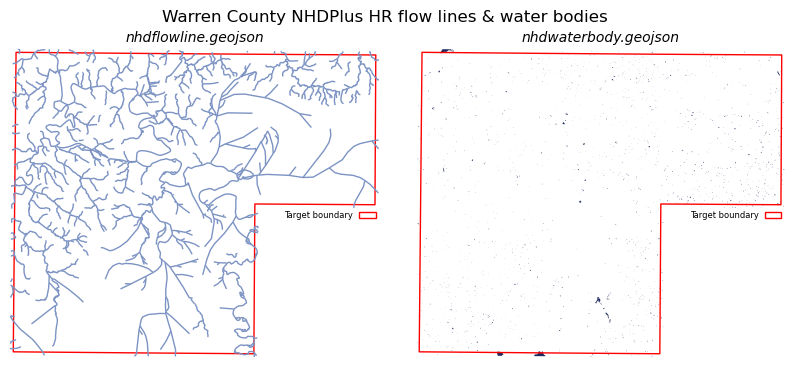

In [29]:
##########################################
# Visualize Flowline & Waterbody GeoJSONs
##########################################

# path to flowline GeoJSON
flowline_path = r'../data/warren/nhdflowline.geojson'

# alphabetized list of paths to hydrography GeoJSONs
waterbody_path = r'../data/warren/nhdwaterbody.geojson'

# path to target dataset boundary
boundary_path = r'../data/warren/boundary.geojson'


##### plot GeoJSONs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# flowlines
gdf_flowline = gpd.read_file(flowline_path)
gdf_flowline.plot(ax=ax[0], facecolor='none', edgecolor='#7C93C3', linewidth=1)
ax[0].set_title('nhdflowline.geojson', style='italic', fontsize=10)

bounds = gdf_flowline.total_bounds

# water bodies
gdf_waterbody = gpd.read_file(waterbody_path)
gdf_waterbody.plot(ax=ax[1], color='#1E2A5E')
ax[1].set_title('nhdwaterbody.geojson', style='italic', fontsize=10)

# dataset boundary
gdf_boundary = gpd.read_file(boundary_path)

for axes in ax:
    gdf_boundary.plot(ax=axes, facecolor='none', edgecolor='red', linewidth=1)

    boundary_patch = Patch(facecolor='none', edgecolor='red', label='Target boundary')
    axes.legend(handles=[boundary_patch], loc='upper left', bbox_to_anchor=(0.925, 0.5), frameon=False, handletextpad=-11, fontsize=6)

    axes.set_axis_off()
    axes.set_xlim(bounds[0], bounds[2])
    axes.set_ylim(bounds[1], bounds[3])

plt.suptitle('Warren County NHDPlus HR flow lines & water bodies')
plt.show()

In [30]:
######################################################
# Combine Flowlines & Waterbodies Into Single GeoTIFF
######################################################

# list of paths to flowline and waterbody GeoJSONs
# NOTE: in this order, waterbody will be prioritized if features overlap
input_paths = [r'../data/warren/nhdflowline.geojson', 
               r'../data/warren/nhdwaterbody.geojson']

# path to reference image (using labeled target dataset)
reference_path = r'../data/warren/geology.tif'

# path for output GeoTIFF
# NOTE: JSON dictionary of labels and GeoTIFF values will also be created with same file basename
output_path = r'../data/warren/nhd.tif'


##### combine features and save as single GeoTIFF
multiple_gis_to_reference_image(input_paths, reference_path, output_path)

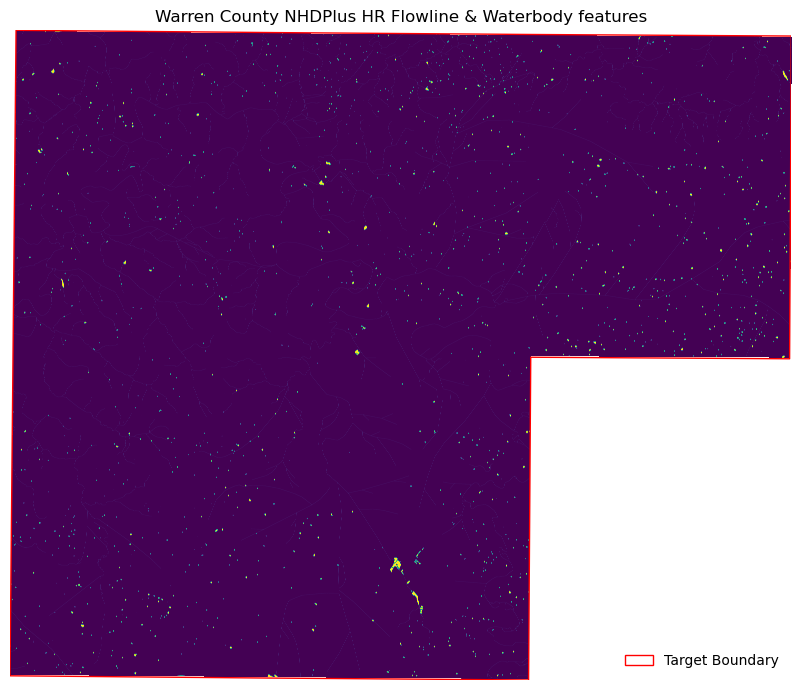

In [40]:
###########################
# Visualize Single GeoTIFF
###########################

# path to single GeoTIFF
nhd_path = r'../data/warren/nhd.tif'

# path to dataset boundary GeoJSON
boundary_path = r'../data/warren/boundary.geojson'


##### visualize combined GeoTIFF
fig, ax = plt.subplots(figsize=(15,7))

with rasterio.open(nhd_path) as src:
    show(src, ax=ax)

boundary = gpd.read_file(boundary_path)
boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

handles = [Patch(facecolor='none', edgecolor='red', linewidth=1, label='Target Boundary')]
ax.legend(handles=handles, loc='lower right', frameon=False, fontsize=10)
ax.set_axis_off()
ax.set_title('Warren County NHDPlus HR Flowline & Waterbody features')
plt.tight_layout()
plt.show()

In [21]:
#########################
# Delete NHD Data Folder
#########################

# path to nhd data folder (not GeoTIFF images)
nhd_dir = r'../data/warren/nhdplushr'


##### remove nhdplushr folder and all contents (to save disk space)
if os.path.isdir(nhd_dir):
    shutil.rmtree(nhd_dir)

# **Roads & Railways**

**OVERVIEW**
* OpenStreetMap (OSM) is a collaborative mapping project that provides freely accessible and up-to-date geospatial data. OSM data is continuously updated by a global community of contributors, making it a valuable resource for mapping current human developments and infrastructure. More information can be found at the OSM website - https://www.openstreetmap.org/about

**PURPOSE**
* Two layers from the OSM dataset will be utilized for this project, including road (gis_osm_roads_free_1) and railway (gis_osm_railways_free_1) centerlines. These features should be useful for identifying areas of artificial fill or areas of manmade alteration to the landscape. These features highlight regions where construction activities, such as road building or railway construction, may have introduced man-made changes to the landscape, such as grading, cutting, or filling.

* Since OSM data is continually updated, features may represent more recent developments that are not reflected in the KyFromAbove DEM or imagery datasets. Although This temporal mismatch could introduce some uncertainty in areas where significant changes have occurred since the DEM or aerial imagery were captured. However, the OSM data can still provide valuable insights into human modifications of the landscape, which are important for predicting surficial geologic map units.

In [24]:
###############################################
# Download OpenStreetMaps Dataset for Kentucky
###############################################

# url for OpenStreetMaps Kentucky dataset download
osm_url = r'http://download.geofabrik.de/north-america/us/kentucky-latest-free.shp.zip'

# directory to save statewide osm dataset
osm_dir = r'../data/osm_ky'
if not os.path.isdir(osm_dir):
    os.makedirs(osm_dir)


##### custom function to download zip, extract contents, and delete .zip
download_zip(osm_url, osm_dir)


##### only save shapefiles for roads & railroads
osm_files = glob.glob(os.path.join(osm_dir, '*.*'))
for path in osm_files:
    if ('gis_osm_roads_free_1' in path) or ('gis_osm_railways_free_1' in path):
        continue
    else:
        os.remove(path)

In [25]:
######################################################################
# Clip to OSM Roads & Railways to Boundary to Target Dataset Boundary
######################################################################

# path to NHDPlus HR geodatabase
osm_paths = glob.glob(r'../data/osm_ky/*.shp')

# path to target boundary GeoJSON
buffered_path = glob.glob(r'../data/warren/*buffer*.geojson')[0]


##### clip roads & railways shapefiles to boundary
for path in osm_paths:
    if 'roads' in path:
        output_path = r'../data/warren/osmroads.geojson'
    if 'railways' in path:
        output_path = r'../data/warren/osmrailways.geojson'
    
    if not os.path.isfile(output_path):
        clip_gis_to_boundary(path, buffered_path, output_path)

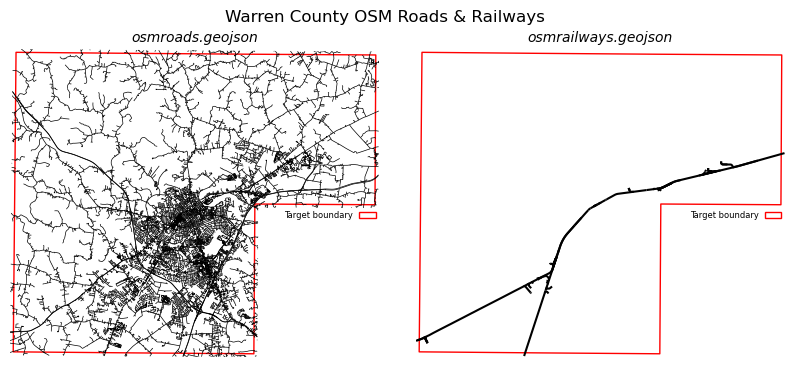

In [28]:
########################################
# Visualize OSM Road & Railway GeoJSONs
########################################

# path to roads GeoJSON
roads_path = r'../data/warren/osmroads.geojson'

# path to railways GeoJSON
rail_path = r'../data/warren/osmrailways.geojson'

# path to target dataset boundary
boundary_path = r'../data/warren/boundary.geojson'


##### plot GeoJSONs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# roads
gdf_roads = gpd.read_file(roads_path)
gdf_roads.plot(ax=ax[0], facecolor='none', edgecolor='k', linewidth=0.5)
ax[0].set_title('osmroads.geojson', style='italic', fontsize=10)

bounds = gdf_roads.total_bounds

# railways
gdf_railways = gpd.read_file(rail_path)
gdf_railways.plot(ax=ax[1], color='k', linewidth=1.5)
ax[1].set_title('osmrailways.geojson', style='italic', fontsize=10)

# dataset boundary
gdf_boundary = gpd.read_file(boundary_path)

for axes in ax:
    gdf_boundary.plot(ax=axes, facecolor='none', edgecolor='red', linewidth=1)

    boundary_patch = Patch(facecolor='none', edgecolor='red', label='Target boundary')
    axes.legend(handles=[boundary_patch], loc='upper left', bbox_to_anchor=(0.925, 0.5), frameon=False, handletextpad=-11, fontsize=6)

    axes.set_axis_off()
    axes.set_xlim(bounds[0], bounds[2])
    axes.set_ylim(bounds[1], bounds[3])

plt.suptitle('Warren County OSM Roads & Railways')
plt.show()

In [32]:
####################################################
# Combine OSM Roads & Railroads Into Single GeoTIFF
####################################################

# list of paths to flowline and waterbody GeoJSONs
# NOTE: in this order, railways will be prioritized if features overlap
input_paths = [r'../data/warren/osmroads.geojson', 
               r'../data/warren/osmrailways.geojson']

# path to reference image (using labeled target dataset)
reference_path = r'../data/warren/geology.tif'

# path for output GeoTIFF
# NOTE: JSON dictionary of labels and GeoTIFF values will also be created with same file basename
output_path = r'../data/warren/osm.tif'


##### combine features and save as single GeoTIFF
multiple_gis_to_reference_image(input_paths, reference_path, output_path)

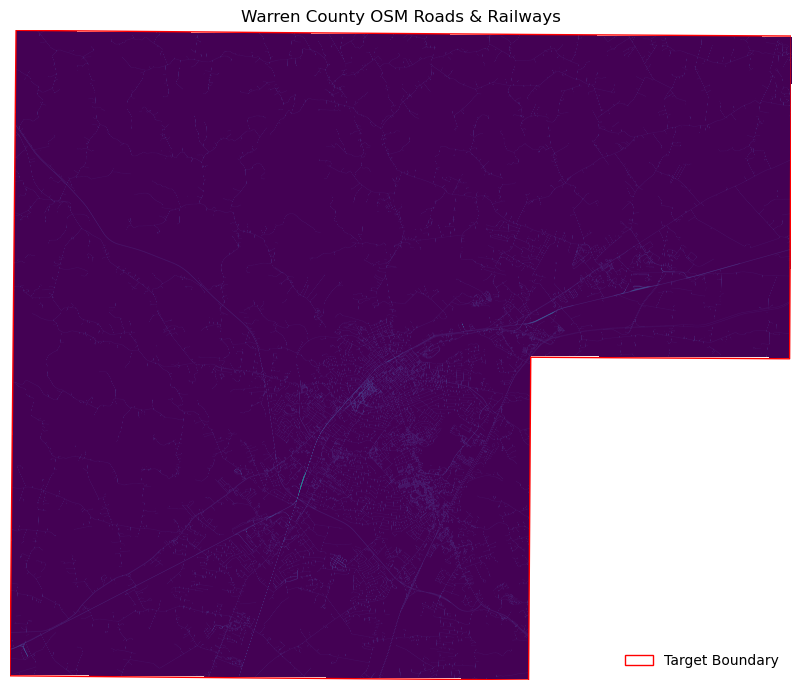

In [41]:
###############################
# Visualize Single OSM GeoTIFF
###############################

# path to single GeoTIFF
nhd_path = r'../data/warren/osm.tif'

# path to dataset boundary GeoJSON
boundary_path = r'../data/warren/boundary.geojson'


##### visualize combined GeoTIFF
fig, ax = plt.subplots(figsize=(15,7))

with rasterio.open(nhd_path) as src:
    show(src, ax=ax)

boundary = gpd.read_file(boundary_path)
boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

handles = [Patch(facecolor='none', edgecolor='red', linewidth=1, label='Target Boundary')]
ax.legend(handles=handles, loc='lower right', frameon=False, fontsize=10)
ax.set_axis_off()
ax.set_title('Warren County OSM Roads & Railways')
plt.tight_layout()
plt.show()

# **Image Alignment**

## *Check Alignment*

In [6]:
########################
# Check Image Alignment
########################
# NOTE: nhd and osm were aligned directly to target geology.tif and should be aligned & registered. DEM, derived terrain features, and aerial were clipped to the buffered boundary and so should be larger (by 2*buffer distance)

# paths to images
image_paths = glob.glob(r'../data/warren/*.tif')
image_paths.sort(key=lambda x: x.lower())

# names of images
image_names = []
for path in image_paths:
    name = os.path.basename(path)
    name = os.path.splitext(name)[0]
    image_names.append(name)


##### compile image alignment information in dataframe
df = pd.DataFrame({'image':image_names, 'path':image_paths})
df[['aligned', 'resolution_x', 'resolution_y', 'width', 'height', 'left', 'bottom', 'right', 'top']] = pd.NA

for image, path in zip(image_names, image_paths):
    with rasterio.open(path) as src:
        df.loc[df['image'] == image, 'resolution_x'] = src.res[0]
        df.loc[df['image'] == image, 'resolution_y'] = src.res[1]
        df.loc[df['image'] == image, 'width'] = src.width
        df.loc[df['image'] == image, 'height'] = src.height
        df.loc[df['image'] == image, 'left'] = src.bounds[0]
        df.loc[df['image'] == image, 'bottom'] = src.bounds[1]
        df.loc[df['image'] == image, 'right'] = src.bounds[2]
        df.loc[df['image'] == image, 'top'] = src.bounds[3]

target_alignment = df.loc[df['image']=='geology', 'resolution_x':].values
df['aligned'] = (df.loc[:, 'resolution_x':]==target_alignment).all(axis=1)

df.head(len(df))

,image,path,aligned,resolution_x,resolution_y,width,height,left,bottom,right,top
0,aerial_b_5ft,../data/warren/aerial_b_5ft.tif,False,5.00,5.00,22436,18722,4664293.00,3477683.50,4776473.00,3571293.50
1,aerial_g_5ft,../data/warren/aerial_g_5ft.tif,False,5.00,5.00,22436,18722,4664293.00,3477683.50,4776473.00,3571293.50
2,aerial_nir_5ft,../data/warren/aerial_nir_5ft.tif,False,5.00,5.00,22436,18722,4664293.00,3477683.50,4776473.00,3571293.50
3,aerial_r_5ft,../data/warren/aerial_r_5ft.tif,False,5.00,5.00,22436,18722,4664293.00,3477683.50,4776473.00,3571293.50
4,dem,../data/warren/dem.tif,False,5.00,5.00,22438,18723,4664290.00,3477680.00,4776480.00,3571295.00
5,geology,../data/warren/geology.tif,True,5.00,5.00,22037,18323,4665293.24,3478678.39,4775478.24,3570293.39
6,nhd,../data/warren/nhd.tif,True,5.00,5.00,22037,18323,4665293.24,3478678.39,4775478.24,3570293.39
7,osm,../data/warren/osm.tif,True,5.00,5.00,22037,18323,4665293.24,3478678.39,4775478.24,3570293.39
8,test,../data/warren/test.tif,True,5.00,5.00,22037,18323,4665293.24,3478678.39,4775478.24,3570293.39


## *Clip to Target Boundary*

In [2]:
#################################
# Clip Images to Target Boundary
#################################

# paths to images that need clipped
input_paths = df.loc[df['aligned']==False, 'path'].to_list()

# path to reference target image to align input
reference_path = r'../data/warren/geology.tif'


##### register and align input images with labeled target dataset
for path in input_paths:
    image_to_reference_image(input_path, reference_path)


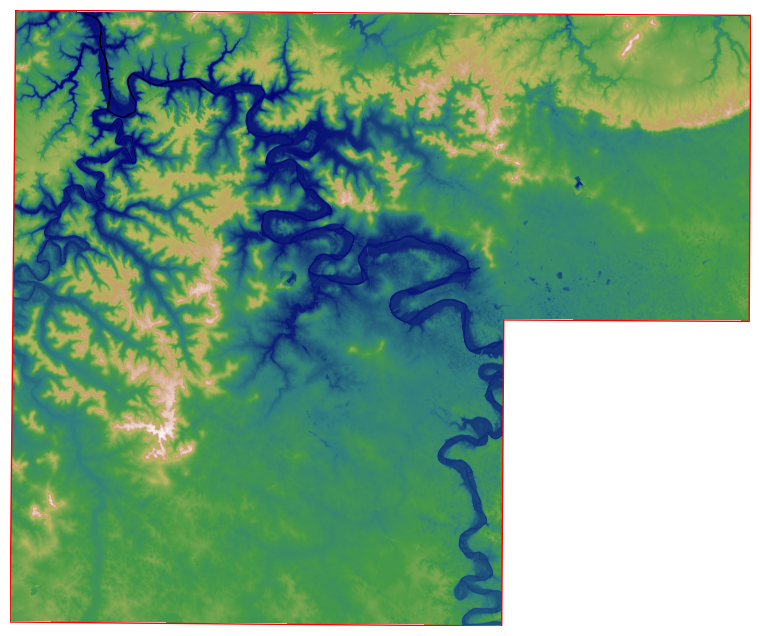

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
with rasterio.open(r'../data/warren/dem.tif') as src:
    show(src, ax=ax, cmap='gist_earth')

gdf = gpd.read_file(r'../data/warren/boundary.geojson')
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
ax.set_axis_off()
plt.show()

## *Reproject to Target Space*

## *Verify Alignment*

# **Image Patches**

## *Create Patches*

## *Encode Patch Features*

## *Final Patch Statistics*

## *Extract Patches*